In [ ]:
!pip install scikit_plot

import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import zipfile 
import cv2
%matplotlib inline

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix

import keras
from keras import models
from keras.layers import *
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop, Adam
from keras.utils import to_categorical

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/fer2013.csv')
data.columns = ['emotion', 'pixels', 'Usage']

In [ ]:
def process_data(data):
    images = np.zeros(shape=(len(data), 48, 48, 1))
    labels = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48)) 
        images[i, :, :, 0] = image / 255

    return images, labels

In [ ]:
emotions_dict = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

training, training_labels = process_data(data[data['Usage']=='Training'])
valid, valid_labels = process_data(data[data['Usage']=='PrivateTest'])
testing, testing_labels = process_data(data[data['Usage']=='PublicTest'])

In [ ]:
# 1 input layer
# 6 hidden layers 1 of them is dense
# 1 output layer
# activation function elu instead of relu
# "same" such that output has the same height/width dimension as the input.

def build_model(optim):
    cnn = Sequential()

    cnn.add(Conv2D(filters=64, kernel_size=(5, 5), activation='elu', padding='same', kernel_initializer='he_normal', input_shape=(48, 48, 1)))
    cnn.add(BatchNormalization())

    cnn.add(Conv2D(filters=64, kernel_size=(5, 5), activation='elu', padding='same', kernel_initializer='he_normal'))
    cnn.add(BatchNormalization())
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    cnn.add(Dropout(0.4))

    cnn.add(Conv2D(filters=128, kernel_size=(3, 3), activation='elu', padding='same', kernel_initializer='he_normal'))
    cnn.add(BatchNormalization())

    cnn.add(Conv2D(filters=128, kernel_size=(3, 3), activation='elu', padding='same', kernel_initializer='he_normal'))
    cnn.add(BatchNormalization())
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    cnn.add(Dropout(0.4))

    cnn.add(Conv2D(filters=256, kernel_size=(3, 3), activation='elu', padding='same', kernel_initializer='he_normal'))
    cnn.add(BatchNormalization())

    cnn.add(Conv2D(filters=256, kernel_size=(3, 3), activation='elu', padding='same', kernel_initializer='he_normal'))
    cnn.add(BatchNormalization())
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    cnn.add(Dropout(0.5))

    cnn.add(Flatten())
    cnn.add(Dense(128, activation='elu', kernel_initializer='he_normal'))
    cnn.add(BatchNormalization())
    cnn.add(Dropout(0.6))
    
    cnn.add(Dense(7, activation='softmax'))
    
    cnn.compile(loss='categorical_crossentropy',
                optimizer=optim,
                metrics=['accuracy'])
    
    cnn.summary()
    
    return cnn

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1)

callbacks = [
    early_stopping,
    reduce_lr]


train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)

train_datagen.fit(training)
  
training_l = to_categorical(training_labels, 7)
valid_l = to_categorical(valid_labels, 7)

def random_search(params, num_iter, train, train_labels, valid, valid_labels, epochs):
    models = {}
    for i in range(num_iter):
        print("Iter : "  + str(i))
        passing_param = {}
        lr = random.choice(params["lr"])
        decay = random.choice(params["decay"])
        passing_param.update({"decay":decay})
        passing_param.update({"lr":lr})
        batch = random.choice(params["batch_size"])

        model = build_model(optimizers.Adam(lr=lr, decay=decay))
        passing_param.update({"batch":batch})
        print("Params: " + str(passing_param))
        history = model.fit(train_datagen.flow(train, train_labels, batch_size=batch),
                            validation_data = (valid, valid_labels),
                            steps_per_epoch = len(training) / batch,
                            epochs = epochs,
                            callbacks = callbacks)
        print(model)
        val_acc = max(history.history['val_accuracy'])
        models.update({str(passing_param): val_acc})
    return models


lr = [0.0005, 0.001, 0.0015]
decay = [1e-9, 1e-8, 1e-7]
batch_size = [16, 32, 64, 128]
params = {"lr": lr, "decay" : decay, "batch_size" : batch_size}
models = random_search(params, 6, training, training_l, valid, valid_l, 100)
models

Iter : 0
[0.0005, 0.001, 0.0015]
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_63 (Conv2D)           (None, 48, 48, 64)        1664      
_________________________________________________________________
batch_normalization_63 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 48, 48, 64)        102464    
_________________________________________________________________
batch_normalization_64 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_93 (Dropout)         (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_65 (Conv2D)  

{"{'decay': 1e-08, 'lr': 0.001, 'batch': 128}": 0.6876567006111145,
 "{'decay': 1e-08, 'lr': 0.001, 'batch': 16}": 0.6957369446754456,
 "{'decay': 1e-09, 'lr': 0.0005, 'batch': 128}": 0.6868208646774292,
 "{'decay': 1e-09, 'lr': 0.001, 'batch': 128}": 0.6954583525657654,
 "{'decay': 1e-09, 'lr': 0.0015, 'batch': 16}": 0.6898857355117798,
 "{'decay': 1e-09, 'lr': 0.0015, 'batch': 32}": 0.6946224570274353}

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    reduce_lr,
]

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)

train_datagen.fit(training)

training_l = to_categorical(training_labels, 7)
valid_l = to_categorical(valid_labels, 7)

batch_size = 16 # best results with this batch size according to random search
epochs = 100

model = build_model(Adam(lr=0.001, decay=1e-8)) # best learning rate and decay according to random search

history = model.fit(
    train_datagen.flow(training, training_l, batch_size=batch_size),
    validation_data=(valid, valid_l),
    steps_per_epoch=len(training) / batch_size,
    epochs=epochs,
    callbacks=callbacks)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        1664      
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       7

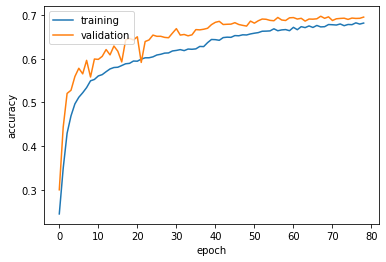

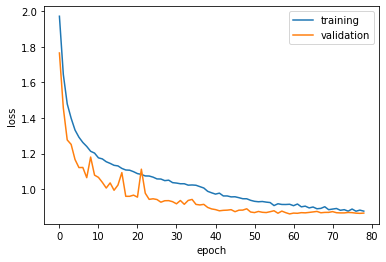

In [ ]:
def visualize_accuracy(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['training', 'validation'], loc='upper left')
  plt.show()

def visualize_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['training', 'validation'], loc='upper right')
  plt.show()

visualize_accuracy(history)
visualize_loss(history)

In [ ]:
model.save('last_model.h5')

In [ ]:
my_model = keras.models.load_model("/content/drive/MyDrive/last_model.h5")

In [ ]:
testing_prediction = np.argmax(my_model.predict(testing), axis=1)
testing_accuracy = np.mean(testing_prediction == testing_labels)

print(testing_accuracy)

0.6701030927835051
